In [1]:
import requests
import pandas as pd
import json
import psycopg2
from sqlalchemy import create_engine 
from dask.diagnostics import ProgressBar
import dask.dataframe as dd
import dask.array as da
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import datetime
from nltk.stem import WordNetLemmatizer
import re
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from scipy.sparse import vstack, hstack, csr_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
#stop_words = set(stopwords.words('english'))
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib as mpl
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
import dask_ml.feature_extraction.text

import numpy as np
import pandas as pd
import string
import spacy
import pickle

import dask.dataframe as dd
from dask.distributed import Client
from dask_ml.model_selection import train_test_split
from dask_ml.feature_extraction.text import HashingVectorizer
from dask_ml.wrappers import Incremental
from dask_ml.metrics import accuracy_score

from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.utils import class_weight
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report

# OBJECTIVE

From the previous analysis we found that 

1. The dataset contains features that are not necessary to solve our **multi-classification problem**. 

2. For this **text classification problem**, we are going to build another dataframe that contains ‘Descriptor’ and ‘Compalint Type’



# PIPELINE

1. Text Classifiction problems can be modelled well with Linear SVC, Naive Bayers, Random Forests

2. Modelling the Prediction of Compalint based on Descriptor

In [2]:
df = dd.read_csv("C:\\NYCOpendata\\Queens.csv",error_bad_lines=False)
df = df.compute()

In [3]:
def remove_digits(x):
    x = ''.join([i for i in x if not i.isdigit()])
    return x

import string
def remove_punctuation(sentence: str) -> str:
    return sentence.translate(str.maketrans('', '', string.punctuation))

import nltk
nltk.download('punkt')

from nltk.corpus import stopwords
nltk.download('stopwords')

stop = stopwords.words('english')

def remove_stop_words(x):
    x = ' '.join([i for i in x.lower().split(' ') if i not in stop])
    return x

def to_lower(x):
    return x.lower()


from nltk.stem.porter import PorterStemmer

porter = PorterStemmer()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pavani.nrusimhadevar\AppData\Roaming\nltk_dat
[nltk_data]     a...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pavani.nrusimhadevar\AppData\Roaming\nltk_dat
[nltk_data]     a...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
df["Resolution Description"]= df["Resolution Description"].astype(str)
df["Descriptor"]= df["Descriptor"].astype(str) 

df['Descriptor'] = df['Descriptor'].apply(to_lower)
df["Descriptor"]= df["Descriptor"].astype(str) 
df['Descriptor'] = df['Descriptor'].apply(remove_stop_words)
df['Descriptor'] = df['Descriptor'].apply(remove_digits)
df['Descriptor'] = df['Descriptor'].apply(remove_punctuation)
df['Descriptor']= df['Descriptor'].apply(porter.stem)
df['Resolution Description'] = df['Resolution Description'].apply(to_lower)
df['Resolution Description'] = df['Resolution Description'].apply(remove_stop_words)
df['Resolution Description'] = df['Resolution Description'].apply(remove_digits)
df['Resolution Description'] = df['Resolution Description'].apply(remove_punctuation)
df['Resolution Description']= df['Resolution Description'].apply(porter.stem)

In [5]:
df['Location Type'] = df['Location Type'].astype(str) 
df['Location Type'] = df['Location Type'].apply(to_lower)
df['Location Type'] = df['Location Type'].apply(remove_punctuation)

In [6]:
df.head()

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,...,Park Facility Name,Park Borough,Latitude,Longitude,Location,Total_Time,Resolution_Time,Year,Month,DayofWeek
0,27842659,2014-04-14 13:27:00,2014-04-14 15:03:00,DEP,Department of Environmental Protection,Sewer,sewer backup use comments sa,nan,11428,220-05 93 AVENUE,...,Unspecified,QUEENS,40.722790,-73.735491,"(40.722789705537885, -73.73549132976942)",0.0,0.0,2014,4,0
1,27842663,2014-04-14 12:35:00,2014-04-14 14:28:00,DEP,Department of Environmental Protection,Sewer,sewer backup use comments sa,nan,11434,132-41 BENNETT COURT,...,Unspecified,QUEENS,40.678152,-73.762001,"(40.678151620421175, -73.76200138093122)",0.0,0.0,2014,4,0
2,27842672,2014-04-14 01:11:00,2014-04-14 07:00:00,DEP,Department of Environmental Protection,Water System,hydrant leaking wc,nan,11370,NaN,...,Unspecified,QUEENS,40.766705,-73.890236,"(40.766704728837894, -73.89023597243937)",0.0,0.0,2014,4,0
3,27842673,2014-04-14 07:43:00,2014-04-14 07:55:00,DEP,Department of Environmental Protection,Water System,leak use comments wa,nan,11355,136-13 41 AVENUE,...,Unspecified,QUEENS,40.758676,-73.829084,"(40.75867596109416, -73.82908396074494)",0.0,0.0,2014,4,0
4,27842676,2014-04-14 15:40:00,2014-05-30 10:15:00,DEP,Department of Environmental Protection,Water System,hydrant leaking wc,nan,11357,147-15 7 AVENUE,...,Unspecified,QUEENS,40.793684,-73.820933,"(40.793683752861675, -73.82093313934396)",45.0,45.0,2014,4,0


In [7]:
df= df[df['Longitude'].notnull()]
df= df[df['Latitude'].notnull()]
df= df[df['Location'].notnull()]
df['Complaint Type'] = df['Complaint Type'].apply(remove_punctuation)
df['Complaint Type'] = df['Complaint Type'].apply(to_lower)
df[['Complaint Type','Descriptor','Resolution Description']].head()

,Complaint Type,Descriptor,Resolution Description
0,sewer,sewer backup use comments sa,department environmental protection investigat...
1,sewer,sewer backup use comments sa,department environmental protection investigat...
2,water system,hydrant leaking wc,department environmental protection determined...
3,water system,leak use comments wa,department environmental protection determined...
4,water system,hydrant leaking wc,department environmental protection investigat...


#### Target Variable Rephrasing

In [8]:
df['Complaint Type'] = df['Complaint Type'].replace(df[df['Complaint Type'].str.contains("heat") ]["Complaint Type"].unique(),'HeatComplaints')
df['Complaint Type'] = df['Complaint Type'].replace(df[df['Complaint Type'].str.contains("noise") ]["Complaint Type"].unique(), 'NoiseComplaints')
df['Complaint Type'] = df['Complaint Type'].replace(df[df['Complaint Type'].str.contains("construction|plumbing") ]["Complaint Type"].unique(),'Construction/PlumbingComplaints')
df['Complaint Type'] = df['Complaint Type'].replace(df[df['Complaint Type'].str.contains("dof") ]["Complaint Type"].unique(),'DOFComplaints')
df['Complaint Type'] = df['Complaint Type'].replace(df[df['Complaint Type'].str.contains("parking|blocked driveway|park") ]["Complaint Type"].unique(),'ParkingComplaints')
df['Complaint Type'] = df['Complaint Type'].replace(df[df['Complaint Type'].str.contains("paint") ]["Complaint Type"].unique(),'Paint/PlasterComplaints')
df['Complaint Type'] = df['Complaint Type'].replace(df[df['Complaint Type'].str.contains("water") ]["Complaint Type"].unique(),'WaterComplaints')
df['Complaint Type'] = df['Complaint Type'].replace(df[df['Complaint Type'].str.contains("dirt|sanitation condition") ]["Complaint Type"].unique(),'SanitationComplaints')
df['Complaint Type'] = df['Complaint Type'].replace(df[df['Complaint Type'].str.contains("highway") ]["Complaint Type"].unique(),'HighwayComplaints')
df['Complaint Type'] = df['Complaint Type'].replace(['street light condition', 'street condition',
       'street sign  damaged', 'sidewalk condition', 'dead tree',
       'street sign  dangling', 'street sign  missing', 'damaged tree',
       'new tree request', 'illegal tree damage',
       'rootsewersidewalk condition', 'overgrown treebranches',
       'request xmas tree collection', 'deaddying tree',
       'dep sidewalk condition','graffiti','derelict vehicles',
       'for hire vehicle complaint', 'derelict vehicle',
       'for hire vehicle report', 'abandoned vehicle',
       'city vehicle placard complaint'],'StreetComplaints')

df['Complaint Type'] = df['Complaint Type'].replace(df[df['Complaint Type'].str.contains("sewer|sewage") ]["Complaint Type"].unique(),'SewerComplaints')
df['Complaint Type'] = df['Complaint Type'].replace(df[df['Complaint Type'].str.contains("homeless") ]["Complaint Type"].unique(),'HomelessComplaints')
df['Complaint Type'] = df['Complaint Type'].replace(['traffic signal condition', 'traffic'],'TrafficComplaints')
df['Complaint Type'] = df['Complaint Type'].replace(['taxi complaint', 'taxi report', 'taxi compliment',
       'green taxi report', 'dispatched taxi complaint'],'TaxiComplaints')
df['Complaint Type'] = df['Complaint Type'].replace(['doorwindow', 'flooringstairs', 'buildinguse', 'outside building',
       'vacant apartment', 'building marshals office',
       'building condition','elevator'],'BuildingComplaints')
pd.set_option('display.max_rows', None)
df['Complaint Type'].value_counts()
df.loc[~df["Complaint Type"].isin(['NoiseComplaints',
'HeatComplaints',                           
'StreetComplaints',                         
'Construction/PlumbingComplaints',                    
'SanitationComplaints',                     
'WaterComplaints',                         
'BuildingComplaints',                       
'Paint/PlasterComplaints',                   
'TaxiComplaints',                           
'HomelessComplaints',
'DOFComplaints',
'HighwayComplaints',
'ParkingComplaints',
'broken muni meter',                        
'rodent',                                   
'consumer complaint',                      
'electric',                                  
'general',                                 
'SewerComplaints',                          
'request large bulky item collection',      
'air quality',                                
'nonconst',                                 
'TrafficComplaints',                         
'vending',                                   
'food establishment',                       
'missed collection all materials' ]), "Complaint Type"] = "Other Complaints"

In [9]:
df['Complaint Type'] = df['Complaint Type'].replace(['vending'],'StreetComplaints')
df['Complaint Type'].value_counts()

StreetComplaints                       947344
ParkingComplaints                      677899
NoiseComplaints                        604892
Other Complaints                       314282
HeatComplaints                         239114
Construction/PlumbingComplaints        220697
WaterComplaints                        218191
SanitationComplaints                   191305
BuildingComplaints                     172033
SewerComplaints                        143956
request large bulky item collection    129673
TrafficComplaints                       94872
missed collection all materials         87082
Paint/PlasterComplaints                 62480
rodent                                  43690
consumer complaint                      41393
electric                                36661
broken muni meter                       31654
TaxiComplaints                          23446
nonconst                                23068
general                                 17989
air quality                       

#### Location Type Rephrasing

In [10]:
df['Location Type'] = df['Location Type'].replace(df[df['Location Type'].str.contains("residential") ]["Location Type"].unique(),'RESIDENTIAL')
df['Location Type'] = df['Location Type'].replace(df[df['Location Type'].str.contains("school") ]["Location Type"].unique(),'SCHOOL')
df['Location Type'] = df['Location Type'].replace(df[df['Location Type'].str.contains("apartment") ]["Location Type"].unique(),'APARTMENT')
df['Location Type'] = df['Location Type'].replace(df[df['Location Type'].str.contains("comercial|commercial") ]["Location Type"].unique(),'COMMERCIAL')
df['Location Type'] = df['Location Type'].replace(['public gardenpark', 'park', 'parkplayground', 'public parkgarden'],'PARK')
df['Location Type'] = df['Location Type'].replace(df[df['Location Type'].str.contains("restaurant") ]["Location Type"].unique(),'RESTAURANT')


In [11]:
df['Location Type'].value_counts()

nan                                   1142242
RESIDENTIAL                           1012835
streetsidewalk                         885003
street                                 581992
sidewalk                               461965
RESTAURANT                              50445
COMMERCIAL                              44488
lot                                     29083
12 family dwelling                      27539
street address                          27227
PARK                                    17017
highway                                 12159
3 family apt building                   10841
mixed use                                7133
other explain below                      6970
APARTMENT                                6735
streetcurbside                           6330
curb                                     5123
bus stop shelter                         4133
other                                    3659
SCHOOL                                   3255
property address                  

#### Status

In [12]:
df.loc[((df['Status']!='Closed') & (df['Year'] == 2012) 
       & (df['Resolution Description'].str.contains("investigated|submitted|reviewed|inspected"))) , "Status"] = "Closed"

In [13]:
df.loc[((df['Status']!='Closed' ) 
       & (df['Descriptor'].str.contains("derelict vehicl") ) 
       & (df['Resolution Description'].str.contains("removed"))) , "Status"] = "Closed"

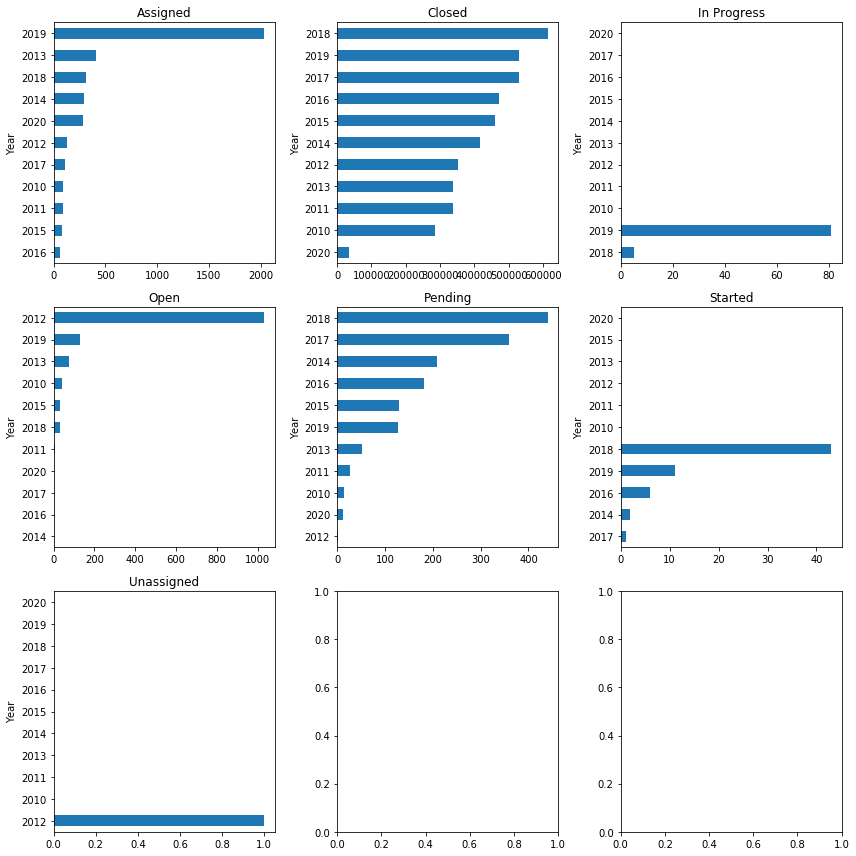

In [14]:
borough_comp = df.groupby(['Year','Status']).size().unstack()

col_number = 3
row_number = 3
fig, axes = plt.subplots(row_number,col_number, figsize=(12,12))

for i, (label,col) in enumerate(borough_comp.iteritems()):
    ax = axes[int(i/col_number), i%col_number]
    col = col.sort_values(ascending=True)[:15]
    col.plot(kind='barh', ax=ax)
    ax.set_title(label)
    
plt.tight_layout()

In [15]:
df = df[df['Location Type']!='nan']
df = df[df['Resolution Description']!='nan']

In [16]:
df.head(2).T

,9,22
Unique Key,27842711,27842762
Created Date,2014-04-14 09:36:00,2014-04-14 19:06:00
Closed Date,2014-04-15 12:00:00,2014-04-14 19:06:00
Agency,DSNY,DSNY
Agency Name,BCC - Queens East,BCC - Queens West
Complaint Type,SanitationComplaints,StreetComplaints
Descriptor,dead anim,derelict vehicl
Location Type,sidewalk,street
Incident Zip,11432,11385
Incident Address,185-19 HILLSIDE AVENUE,1718 NORMAN STREET


In [17]:
df1 = df[['Agency','Location Type','Complaint Type','Descriptor','Resolution_Time','Total_Time','Year','Month','DayofWeek','Status','Resolution Description']]

In [18]:
df1.shape

(3094693, 11)

In [19]:
#df_model = df1.head(60000)

In [20]:
df_model = df1

In [21]:
df_model.head()

,Agency,Location Type,Complaint Type,Descriptor,Resolution_Time,Total_Time,Year,Month,DayofWeek,Status,Resolution Description
9,DSNY,sidewalk,SanitationComplaints,dead anim,1.0,1.0,2014,4,0,Closed,department sanitation investigated complaint f...
22,DSNY,street,StreetComplaints,derelict vehicl,0.0,0.0,2014,4,0,Closed,department sanitation removed item
23,DOHMH,12 family dwelling,Other Complaints,animal wast,4.0,4.0,2014,4,0,Closed,department health mental hygiene review compla...
24,DOHMH,12 family dwelling,Other Complaints,animal odor,9.0,9.0,2014,4,0,Closed,department health mental hygiene review compla...
26,HPD,RESIDENTIAL,WaterComplaints,heavy flow,15.0,15.0,2014,4,0,Closed,department housing preservation development in...


### Create a new column 'complaint_id' with encoded Complaint Types

In [ ]:
df_model['complaint_id'] = df_model['Complaint Type'].factorize()[0]
complaint_id_df = df_model[['Complaint Type', 'complaint_id']].drop_duplicates()


# Dictionaries for future use
category_to_id = dict(complaint_id_df.values)
id_to_category = dict(complaint_id_df[['complaint_id', 'Complaint Type']].values)

# New dataframe
df_model.head()

### Text Preprocessing

In [ ]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')

In [ ]:
df_model.head()

**TF/IDF**

1. TERM FREQUENCY (TF)  = Number of times term appears in doc / Total number of words in doc

2. IDF = ln(no of docs / no of docs term appears in)

3. TF-IDF gives **word frequency** scores

4. ngrams(1,2) --> gives UNIGRAMS AND BIGRAMS

5. min_df: **remove the words** from the vocabulary which have occurred in less than ‘min_df’ number of files

As we knew descriptor is one of the important feature

### TFIDF on "Descriptor"

In [ ]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')

# We transform each complaint into a vector
features = tfidf.fit_transform(df_model['Descriptor']).toarray()

labels = df_model.complaint_id

print("Each of the %d complaints is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))

#### Trying to Find most correlated terms of descriptor for each complaint type

In [ ]:
 #Finding the three most correlated terms with each of the complaint categories
N = 3
for Product, complaint_id in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels == complaint_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("\n==> %s:" %(Product))
    print("  * Most Correlated Unigrams are: %s" %(', '.join(unigrams[-N:])))
    print("  * Most Correlated Bigrams are: %s" %(', '.join(bigrams[-N:])))

############################################################################################

1. Multinominal Niave Bayes is most suitable for **word counts** where data are typically represented as word vector counts and  ignores non-occurrences of a feature i

2. Naive Bayes is a simplified version of Bayes Theorem, where all features are assumed **conditioned independent** to each other (the classifiers), P(x|y) where x is the feature and y is the classifier

#############################################################################################

1. Linear SVC works well on text classification is a part of SVM best for multi class text classification

2. For larger datasts SVM is not a better option as compared to naive bayes it takes more time 

3. If classes are over lapping( not in the case of our exampels) it doesnt work well

 

In [ ]:
models = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
    LinearSVC(),
    MultinomialNB(),
]

# 5 Cross-validation
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

In [ ]:
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1, 
          ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc

#### Model Evaluation

In [ ]:
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(features, 
                                                               labels, 
                                                               df_model.index, test_size=0.25, 
                                                               random_state=1)
model = LinearSVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [ ]:
# Classification report
from sklearn import metrics
print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(metrics.classification_report(y_test, y_pred, 
                                    target_names= df_model['Complaint Type'].unique()))

In [ ]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=complaint_id_df['Complaint Type'].values, 
            yticklabels=complaint_id_df['Complaint Type'].values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - RF\n", size=10);

### Seeing what complaints are classified different

In [ ]:
for predicted in complaint_id_df.complaint_id:
    for actual in complaint_id_df.complaint_id:
        if predicted != actual and conf_mat[actual, predicted] >= 20:
            print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], 
                                                           id_to_category[predicted], 
                                                           conf_mat[actual, predicted]))
            display(df_model.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['Complaint Type','Descriptor','Resolution Description']])
            print('')

#### Most correlated terms in each compalint

In [ ]:
model.fit(features, labels)

N = 4
for Product, complaint_id in sorted(category_to_id.items()):
    indices = np.argsort(model.coef_[complaint_id])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
    bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
    print("\n==> '{}':".format(Product))
    print("  * Top unigrams: %s" %(', '.join(unigrams)))
    print("  * Top bigrams: %s" %(', '.join(bigrams)))

### Predictions

In [ ]:
X = df_model['Descriptor']
y = df_model['Complaint Type']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, 
                                                    test_size=0.25,
                                                    random_state = 0)

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')

fitted_vectorizer = tfidf.fit(X_train)
tfidf_vectorizer_vectors = fitted_vectorizer.transform(X_train)

model = LinearSVC().fit(tfidf_vectorizer_vectors, y_train)

##### I am predicting my model for new descriptors

In [ ]:
new_descriptor1 = """loud"""
print(model.predict(fitted_vectorizer.transform([new_descriptor1])))

In [ ]:
new_descriptor2 = """rod"""
print(model.predict(fitted_vectorizer.transform([new_descriptor2])))

In [ ]:
new_descriptor3 = """dirty"""
print(model.predict(fitted_vectorizer.transform([new_descriptor3])))

##### TF IDF Vectorization

cv = CountVectorizer(min_df=10)
X_agency = cv.fit_transform(df_model['Agency'])
print(X_agency)

##### Apply TFIDF to "resolution description", 
tv = TfidfVectorizer(max_features=55000, ngram_range=(1, 2), stop_words='english')
X_description = tv.fit_transform(df_model['Resolution Description'])

tv = TfidfVectorizer(max_features=55000, ngram_range=(1, 2), stop_words='english')
X_descriptor = tv.fit_transform(df_model['Descriptor'])

lb = LabelBinarizer(sparse_output=True)
X_status = lb.fit_transform(df_model['Status'])

lb = LabelBinarizer(sparse_output=True)
X_comtype = lb.fit_transform(df_model['Complaint Type'])

lb = LabelBinarizer(sparse_output=True)
X_loctype = lb.fit_transform(df_model['Location Type'])

##### Create our final sparse matrix
X_dummies = csr_matrix(pd.get_dummies(df_model[['Total_Time', 'Resolution_Time','Year','Month','DayofWeek']], sparse=True).values)

###### Combine everything together
sparse_merge = hstack((X_dummies, X_description, X_descriptor, X_status, X_loctype)).tocsr()

print("nrows",sparse_merge.shape[0])

In [22]:
import string
import spacy
import pickle

import dask.dataframe as dd
from dask.distributed import Client
from dask_ml.model_selection import train_test_split
from dask_ml.feature_extraction.text import HashingVectorizer
from dask_ml.wrappers import Incremental
from dask_ml.metrics import accuracy_score

from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.utils import class_weight
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report

In [23]:
df_model.shape

(3094693, 11)

### DASK ML

In [24]:
from dask import dataframe as dd 
sd = dd.from_pandas(df_model, npartitions=3)
print (sd)

Dask DataFrame Structure:
               Agency Location Type Complaint Type Descriptor Resolution_Time Total_Time   Year  Month DayofWeek  Status Resolution Description
npartitions=3                                                                                                                                  
0              object        object         object     object         float64    float64  int64  int64     int64  object                 object
39271             ...           ...            ...        ...             ...        ...    ...    ...       ...     ...                    ...
79259             ...           ...            ...        ...             ...        ...    ...    ...       ...     ...                    ...
133380            ...           ...            ...        ...             ...        ...    ...    ...       ...     ...                    ...
Dask Name: from_pandas, 3 tasks


In [25]:
from dask.distributed import Client

client = Client(threads_per_worker=2,n_workers=5, memory_limit='3GB')
client

Client Scheduler: tcp://127.0.0.1:49546 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 5 Cores: 10 Memory: 15.00 GB


In [26]:
X = sd['Descriptor']
ylabels = sd['Complaint Type']

In [27]:
from sklearn.utils import class_weight
keys = np.unique(ylabels.compute())
values = class_weight.compute_class_weight('balanced',
                                           keys,
                                           ylabels.compute())
class_weights = dict(zip(keys, values))


In [28]:
class_weights

{'BuildingComplaints': 3.433420536443356,
 'Construction/PlumbingComplaints': 0.9733869425509483,
 'DOFComplaints': 41.96080106302202,
 'HeatComplaints': 0.5392638727413145,
 'HighwayComplaints': 11.589568727904608,
 'HomelessComplaints': 13.46689730200174,
 'NoiseComplaints': 0.2490926333385491,
 'Other Complaints': 0.5232924600533524,
 'Paint/PlasterComplaints': 2.0637890791720017,
 'ParkingComplaints': 0.19370354096406958,
 'SanitationComplaints': 0.6740312154238868,
 'SewerComplaints': 76.34431122952438,
 'StreetComplaints': 0.1889622057636809,
 'TaxiComplaints': 12.348739864649174,
 'TrafficComplaints': 16.084014178204647,
 'WaterComplaints': 4.870648246077913,
 'broken muni meter': 4.07359391124871,
 'consumer complaint': 417.2994875943905,
 'electric': 3.517240164389042,
 'food establishment': 10.205424746075716,
 'general': 7.197228268958845,
 'missed collection all materials': 1.5108031923826486,
 'nonconst': 5.589801528813363,
 'rodent': 3.097195533991465}

In [50]:
X = sd['Descriptor']
ylabels = sd['Complaint Type']
X_train, X_test, y_train, y_test = train_test_split(X, ylabels, test_size=0.3)

In [51]:
# Create our list of punctuation marks
punctuations = string.punctuation

# Create our list of stopwords
nlp = spacy.load('en')
stop_words = spacy.lang.en.stop_words.STOP_WORDS

# Load English tokenizer, tagger, parser, NER and word vectors
parser = English()

In [52]:
def spacy_tokenizer(sentence):
    # Creating our token object, which is used to create documents with linguistic annotations.
    mytokens = parser(sentence)

    # Lemmatizing each token and converting each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    # Removing stop words
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]

    # return preprocessed list of tokens
    return mytokens

#### Hashing Vecorization (Just like TF-IDF Vectorization in Pandas)

1. text vectorizer implementation uses the hashing trick to find the **token string name to feature integer index mapping**

2. **Less Memory** scaled for Large Data Sets

3. parallel pipeline as there is no state computed during fit.


In [53]:
from dask_ml.feature_extraction.text import HashingVectorizer
hw_vector = HashingVectorizer(tokenizer = spacy_tokenizer, ngram_range=(1, 2), n_features=2**20)

In [54]:
hw_vector

HashingVectorizer(alternate_sign=True, analyzer='word', binary=False,
                  decode_error='strict', dtype=<class 'numpy.float64'>,
                  encoding='utf-8', input='content', lowercase=True,
                  n_features=1048576, ngram_range=(1, 2), norm='l2',
                  preprocessor=None, stop_words=None, strip_accents=None,
                  token_pattern='(?u)\\b\\w\\w+\\b',
                  tokenizer=<function spacy_tokenizer at 0x000001F8034C9AF8>)

In [55]:
%time
Feature_pipeline = Pipeline([('vectorizer', hw_vector)])
Pipeline_Model = Feature_pipeline.fit(X_train.values)

Wall time: 0 ns


In [56]:
Text_preprocess_pipe = pickle.dumps(Pipeline_Model)
Pipeline_Model = pickle.loads(Text_preprocess_pipe)

In [57]:
%time
X_transformed = Pipeline_Model.transform(X_train)

Wall time: 0 ns


In [58]:
%%time
import joblib
estimator = SGDClassifier(random_state=10, max_iter=200, loss='modified_huber',class_weight = class_weights, n_jobs=-1)
classifier = Incremental(estimator)
Model = classifier.fit(X_transformed,y_train,classes=list(class_weights.keys()))

Wall time: 40.1 s


In [59]:
predictions = Model.predict(Pipeline_Model.transform(X_test))
predictions

dask.array<_predict, shape=(nan,), dtype=int32, chunksize=(nan,), chunktype=numpy.ndarray>

In [60]:
ML_Model = pickle.dumps(Model)

In [61]:
%time
Model = pickle.loads(ML_Model)
# X = Model.predict_proba(X_transformed).compute()

Wall time: 0 ns


In [62]:
%time
x_test_transformed = Pipeline_Model.transform(X_test)
y_pred = Model.predict(x_test_transformed).compute()

Wall time: 0 ns


In [63]:
%time
print(classification_report(y_train,Model.predict(Pipeline_Model.transform(X_train)).compute()))

Wall time: 0 ns
                                 precision    recall  f1-score   support

             BuildingComplaints       0.74      1.00      0.85     26408
Construction/PlumbingComplaints       0.99      0.81      0.89     92821
                  DOFComplaints       1.00      1.00      1.00      2113
                 HeatComplaints       1.00      1.00      1.00    167566
              HighwayComplaints       0.90      0.88      0.89      7692
             HomelessComplaints       0.69      1.00      0.82      6727
                NoiseComplaints       1.00      1.00      1.00    362228
               Other Complaints       0.95      0.97      0.96    172739
        Paint/PlasterComplaints       1.00      0.98      0.99     43691
              ParkingComplaints       1.00      0.98      0.99    466482
           SanitationComplaints       1.00      1.00      1.00    133626
                SewerComplaints       1.00      1.00      1.00      1212
               StreetComplaints   

In [64]:
%time
print(classification_report(y_test, y_pred))

Wall time: 0 ns
                                 precision    recall  f1-score   support

             BuildingComplaints       0.73      1.00      0.84     11148
Construction/PlumbingComplaints       0.99      0.81      0.89     39650
                  DOFComplaints       1.00      1.00      1.00       960
                 HeatComplaints       1.00      1.00      1.00     71548
              HighwayComplaints       0.89      0.88      0.89      3434
             HomelessComplaints       0.69      1.00      0.82      2848
                NoiseComplaints       1.00      1.00      1.00    155433
               Other Complaints       0.95      0.97      0.96     73673
        Paint/PlasterComplaints       1.00      0.98      0.99     18789
              ParkingComplaints       1.00      0.98      0.99    199203
           SanitationComplaints       0.99      1.00      1.00     57679
                SewerComplaints       1.00      1.00      1.00       477
               StreetComplaints   

In [65]:
client.close()